<a href="https://colab.research.google.com/github/Subhraj07/Machine_Learning_Models/blob/master/MLpractice/CEREBRINOCS/License_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 7 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,623 kB/s)
debconf: unable to initia

In [8]:
!pip install pytesseract

     |████████████████████████████████| 174kB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/cd/4a/30/998e01b892300ba0ccce7b806b6e889794605a384dac81a49a
Successfully built pytesseract


In [0]:
import cv2
import numpy as np
import math
import random
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.optimizers import RMSprop

In [0]:
image = "/content/drive/My Drive/Vehicle_Licenseplate_Detection/Datasets/LicPlateImages/OS269DT.jpg"

In [0]:
def plot(imgOriginalScene):
  import matplotlib.pyplot as plt
#   imgOriginalScene = cv2.imread(img)
  plt.imshow(imgOriginalScene, cmap="gray")
  plt.show()

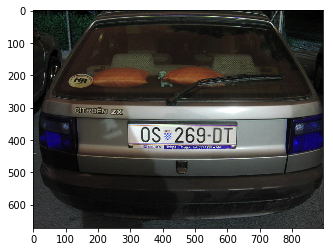

In [30]:
imgOriginalScene = cv2.imread(image)
imgOriginalScene = cv2.resize(imgOriginalScene, (0, 0), fx=1.4, fy=1.4, interpolation=cv2.INTER_CUBIC)
plot(imgOriginalScene)

## detect plates We get a list of plates in the image

In [0]:
listOfPossiblePlates = []
height, width, numChannels = imgOriginalScene.shape
imgContours = np.zeros((height, width, 3), np.uint8)

### preprocess to get grayscale and threshold images

* We get the gray scale of the image.

In [0]:
def extractValue(imgOriginal):
    height, width, numChannels = imgOriginal.shape
    imgHSV = np.zeros((height, width, 3), np.uint8)
    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)
    imgHue, imgSaturation, imgValue = cv2.split(imgHSV)
    return imgValue

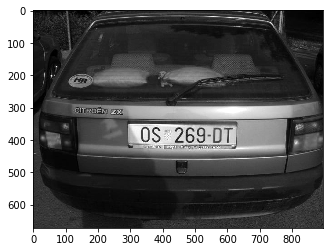

In [33]:
imgGrayscale = extractValue(imgOriginalScene)
plot(imgGrayscale)

* contrast is the difference between light and dark in an image.  
* High contrast images will have bright highlights and dark shadows,bold colours, and show texture in the subject. 
* Low contrast images will have a narrow range of tones and might therefore feel flat or dull


In [0]:
def maximizeContrast(imgGrayscale):
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Same as np.ones((3,3)
    # It is difference of  input image and Opening of the image
    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement)
    
    # it is difference of closing of the input image and input image.
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement)  

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat

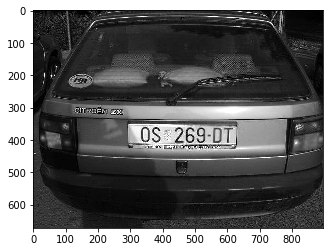

In [35]:
imgMaxContrastGrayscale = maximizeContrast(imgGrayscale)
plot(imgMaxContrastGrayscale)

In [0]:
# module level variables ##########################################################################
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 9

In [0]:
imgGrayscaleScene = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0) # img Blurred
imgThreshScene = cv2.adaptiveThreshold(imgGrayscaleScene, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                                      ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT) # img threshold

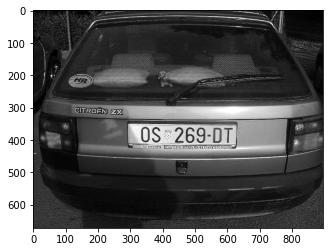

In [40]:
plot(imgGrayscaleScene)

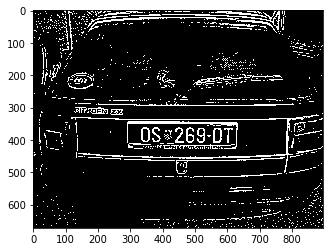

In [41]:
plot(imgThreshScene)

* find all possible chars in the scene, this function first finds all contours, then only includes contours that
* could be chars (without comparison to other chars yet)

In [0]:
class PossibleChar:

    # constructor #################################################################################
    def __init__(self, _contour):
        self.contour = _contour

        # It gives the (x,y,w,h) of a straight rectangle that bounds the contour. It is not sensetive to the rotation of the obejct ,so its area will not be minimum.
        self.boundingRect = cv2.boundingRect(self.contour)  
        [intX, intY, intWidth, intHeight] = self.boundingRect

        self.intBoundingRectX = intX
        self.intBoundingRectY = intY
        self.intBoundingRectWidth = intWidth
        self.intBoundingRectHeight = intHeight

        self.intBoundingRectArea = self.intBoundingRectWidth * self.intBoundingRectHeight

        self.intCenterX = (self.intBoundingRectX + self.intBoundingRectX + self.intBoundingRectWidth) / 2
        self.intCenterY = (self.intBoundingRectY + self.intBoundingRectY + self.intBoundingRectHeight) / 2

        self.fltDiagonalSize = math.sqrt((self.intBoundingRectWidth ** 2) + (self.intBoundingRectHeight ** 2))

        self.fltAspectRatio = float(self.intBoundingRectWidth) / float(self.intBoundingRectHeight)

In [0]:
# module level variables ##########################################################################
# constants for checkIfPossibleChar, this checks one possible char only (does not compare to another char)
MIN_PIXEL_WIDTH = 2
MIN_PIXEL_HEIGHT = 8

MIN_ASPECT_RATIO = 0.25
MAX_ASPECT_RATIO = 1.0

MIN_PIXEL_AREA = 80

# constants for comparing two chars
MIN_DIAG_SIZE_MULTIPLE_AWAY = 0.3
MAX_DIAG_SIZE_MULTIPLE_AWAY = 5.0

MAX_CHANGE_IN_AREA = 0.5

MAX_CHANGE_IN_WIDTH = 0.8
MAX_CHANGE_IN_HEIGHT = 0.2

MAX_ANGLE_BETWEEN_CHARS = 12.0

# other constants
MIN_NUMBER_OF_MATCHING_CHARS = 3

RESIZED_CHAR_IMAGE_WIDTH = 64
RESIZED_CHAR_IMAGE_HEIGHT = 64

MIN_CONTOUR_AREA = 100

SCALAR_BLACK = (0.0, 0.0, 0.0)
SCALAR_WHITE = (255.0, 255.0, 255.0)
SCALAR_YELLOW = (0.0, 255.0, 255.0)
SCALAR_GREEN = (0.0, 255.0, 0.0)
SCALAR_RED = (0.0, 0.0, 255.0)

In [0]:
def checkIfPossibleChar(possibleChar):
    # this function is a 'first pass' that does a rough check on a contour to see if it could be a char,
    # note that we are not (yet) comparing the char to other chars to look for a group
    if (possibleChar.intBoundingRectArea > MIN_PIXEL_AREA and
            possibleChar.intBoundingRectWidth > MIN_PIXEL_WIDTH and possibleChar.intBoundingRectHeight > MIN_PIXEL_HEIGHT and
            MIN_ASPECT_RATIO < possibleChar.fltAspectRatio and possibleChar.fltAspectRatio < MAX_ASPECT_RATIO):
        return True
    else:
        return False

In [0]:
def findPossibleCharsInScene(imgThresh):
    listOfPossibleChars = []  
    intCountOfPossibleChars = 0

    imgThreshCopy = imgThresh.copy()
    
    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_CCOMP,
                                                           cv2.CHAIN_APPROX_SIMPLE)  # find all contours

    height, width = imgThresh.shape
    imgContours = np.zeros((height, width, 3), np.uint8)

    for i in range(0, len(contours)):  # for each contour

        cv2.drawContours(imgContours, contours, i, SCALAR_YELLOW)
        possibleChar = PossibleChar(contours[i])  # Here we calculate the x,y,w,h,flatdiagonalsize,aspedctratio,area and (x,y) of the center of the rectangle that is bounding the contour.

        if checkIfPossibleChar(possibleChar):  # if contour is a possible char, note this does not compare to other chars (yet) . . .
            intCountOfPossibleChars = intCountOfPossibleChars + 1  # increment count of possible chars
            listOfPossibleChars.append(possibleChar)  # and add to list of possible chars
            

    plot(imgContours)
    
    return listOfPossibleChars


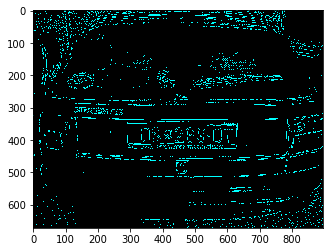

In [50]:
listOfPossibleCharsInScene = findPossibleCharsInScene(imgThreshScene)

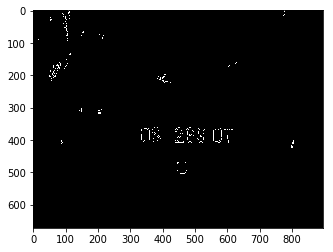

In [57]:
imgContours = np.zeros((height, width, 3), np.uint8)
contours = []

for possibleChar in listOfPossibleCharsInScene:
  contours.append(possibleChar.contour)

cv2.drawContours(imgContours, contours, -1, SCALAR_WHITE)
plot(imgContours)

* given a list of all possible chars, find groups of matching chars
* In the next steps each group of matching chars will attempt to be recognized as a plate

In [0]:
# use Pythagorean theorem to calculate distance between two chars
def distanceBetweenChars(firstChar, secondChar):
    intX = abs(firstChar.intCenterX - secondChar.intCenterX)
    intY = abs(firstChar.intCenterY - secondChar.intCenterY)

    return math.sqrt((intX ** 2) + (intY ** 2))

In [0]:
# use basic trigonometry (SOH CAH TOA) to calculate angle between chars
def angleBetweenChars(firstChar, secondChar):
    fltAdj = float(abs(firstChar.intCenterX - secondChar.intCenterX))
    fltOpp = float(abs(firstChar.intCenterY - secondChar.intCenterY))

    if fltAdj != 0.0:  # check to make sure we do not divide by zero if the center X positions are equal, float division by zero will cause a crash in Python
        fltAngleInRad = math.atan(fltOpp / fltAdj)  # if adjacent is not zero, calculate angle
    else:
        fltAngleInRad = 1.5708  # if adjacent is zero, use this as the angle, this is to be consistent with the C++ version of this program
    # end if

    fltAngleInDeg = fltAngleInRad * (180.0 / math.pi)  # calculate angle in degrees

    return fltAngleInDeg

In [0]:
"""
 the purpose of this function is, given a possible char and a big list of possible chars, find all chars in the
 big list that are a match for the single possible char, and return those matching chars as a list
"""
def findListOfMatchingChars(possibleChar, listOfChars):
    listOfMatchingChars = []  # this will be the return value

    for possibleMatchingChar in listOfChars:  # for each char in big list
        if possibleMatchingChar == possibleChar:  # if the char we attempting to find matches for is the exact same char
            # as the char in the big list we are currently checking
            # then we should not include it in the list of matches b/c that would
            # end up double including the current char
            continue  # so do not add to list of matches and jump back to top of for loop
        # compute stuff to see if chars are a match
        fltDistanceBetweenChars = distanceBetweenChars(possibleChar, possibleMatchingChar)

        fltAngleBetweenChars = angleBetweenChars(possibleChar, possibleMatchingChar)

        fltChangeInArea = float(
            abs(possibleMatchingChar.intBoundingRectArea - possibleChar.intBoundingRectArea)) / float(
            possibleChar.intBoundingRectArea)

        fltChangeInWidth = float(
            abs(possibleMatchingChar.intBoundingRectWidth - possibleChar.intBoundingRectWidth)) / float(
            possibleChar.intBoundingRectWidth)
        fltChangeInHeight = float(
            abs(possibleMatchingChar.intBoundingRectHeight - possibleChar.intBoundingRectHeight)) / float(
            possibleChar.intBoundingRectHeight)

        # check if chars match
        if (fltDistanceBetweenChars < (possibleChar.fltDiagonalSize * MAX_DIAG_SIZE_MULTIPLE_AWAY) and
                fltAngleBetweenChars < MAX_ANGLE_BETWEEN_CHARS and
                fltChangeInArea < MAX_CHANGE_IN_AREA and
                fltChangeInWidth < MAX_CHANGE_IN_WIDTH and
                fltChangeInHeight < MAX_CHANGE_IN_HEIGHT):
            listOfMatchingChars.append(
                possibleMatchingChar)  # if the chars are a match, add the current char to list of matching chars
            # print("\t This contour is same:")
            # cv2.drawContours(imgContours, possibleMatchingChar.contour, -1, SCALAR_WHITE)
            # cv2.imshow("2b", imgContours)
            # cv2.waitKey(0)
        # end if
    # end for

    return listOfMatchingChars  # return result

In [0]:
"""
with this function, we start off with all the possible chars in one big list
the purpose of this function is to re-arrange the one big list of chars into a list of lists of matching chars,
note that chars that are not found to be in a group of matches do not need to be considered further
"""
def findListOfListsOfMatchingChars(listOfPossibleChars):
    listOfListsOfMatchingChars = []  # this will be the return value
    
    # for each possible char in the one big list of chars
    for possibleChar in listOfPossibleChars:
      # find all chars in the big list that match the current char
      listOfMatchingChars = findListOfMatchingChars(possibleChar, listOfPossibleChars)  
      listOfMatchingChars.append(possibleChar)  # also add the current char to current possible list of matching chars
      if len(listOfMatchingChars) < MIN_NUMBER_OF_MATCHING_CHARS:
        # if current possible list of matching chars is not long enough to constitute a possible plate
        continue
      listOfListsOfMatchingChars.append(listOfMatchingChars)
      listOfPossibleCharsWithCurrentMatchesRemoved = list(set(listOfPossibleChars) - set(listOfMatchingChars))
      recursiveListOfListsOfMatchingChars = findListOfListsOfMatchingChars(
      listOfPossibleCharsWithCurrentMatchesRemoved)  # recursive call
      for recursiveListOfMatchingChars in recursiveListOfListsOfMatchingChars:  # for each list of matching chars found by recursive call
          listOfListsOfMatchingChars.append(recursiveListOfMatchingChars)
      break

    return listOfListsOfMatchingChars


In [0]:
listOfListsOfMatchingCharsInScene = findListOfListsOfMatchingChars(listOfPossibleCharsInScene)

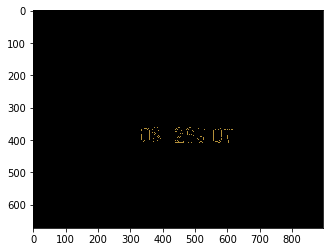

In [64]:
imgContours = np.zeros((height, width, 3), np.uint8)
for listOfMatchingChars in listOfListsOfMatchingCharsInScene:
  intRandomBlue = random.randint(0, 255)
  intRandomGreen = random.randint(0, 255)
  intRandomRed = random.randint(0, 255)
contours = []
for matchingChar in listOfMatchingChars:
  contours.append(matchingChar.contour)
cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
plot(imgContours)

In [0]:
class PossiblePlate:

    # constructor #################################################################################
    def __init__(self):
        self.imgPlate = None
        self.imgGrayscale = None
        self.imgThresh = None

        self.rrLocationOfPlateInScene = None

        self.strChars = ""

In [0]:
# module level variables ##########################################################################
PLATE_WIDTH_PADDING_FACTOR = 1.3
PLATE_HEIGHT_PADDING_FACTOR = 1.5

In [0]:
def extractPlate(imgOriginal, listOfMatchingChars):
    possiblePlate = PossiblePlate()  # this will be the return value

    listOfMatchingChars.sort(
        key=lambda matchingChar: matchingChar.intCenterX)  # sort chars from left to right based on x position

    # calculate the center point of the plate
    fltPlateCenterX = (listOfMatchingChars[0].intCenterX + listOfMatchingChars[
        len(listOfMatchingChars) - 1].intCenterX) / 2.0
    fltPlateCenterY = (listOfMatchingChars[0].intCenterY + listOfMatchingChars[
        len(listOfMatchingChars) - 1].intCenterY) / 2.0
    # This is the probable centeral point of this plate.
    ptPlateCenter = fltPlateCenterX, fltPlateCenterY

    # calculate plate width and height
    intPlateWidth = int((listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectX + listOfMatchingChars[
        len(listOfMatchingChars) - 1].intBoundingRectWidth - listOfMatchingChars[
                             0].intBoundingRectX) * PLATE_WIDTH_PADDING_FACTOR)
    # Here we calculate the probable width of this plate.
    intTotalOfCharHeights = 0

    for matchingChar in listOfMatchingChars:
        intTotalOfCharHeights = intTotalOfCharHeights + matchingChar.intBoundingRectHeight

    fltAverageCharHeight = intTotalOfCharHeights / len(
        listOfMatchingChars)  # Here we calculate the probale height of this particular plate.

    intPlateHeight = int(fltAverageCharHeight * PLATE_HEIGHT_PADDING_FACTOR)  # We include the padding factor.

    # calculate correction angle of plate region
    fltOpposite = listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY - listOfMatchingChars[0].intCenterY
    fltHypotenuse = distanceBetweenChars(listOfMatchingChars[0], listOfMatchingChars[len(listOfMatchingChars) - 1])
    fltCorrectionAngleInRad = math.asin(fltOpposite / fltHypotenuse)
    fltCorrectionAngleInDeg = fltCorrectionAngleInRad * (180.0 / math.pi)

    # pack plate region center point, width and height, and correction angle into rotated rect member variable of plate
    possiblePlate.rrLocationOfPlateInScene = (
        tuple(ptPlateCenter), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg)

    # final steps are to perform the actual rotation

    # get the rotation matrix for our calculated correction angle
    rotationMatrix = cv2.getRotationMatrix2D(tuple(ptPlateCenter), fltCorrectionAngleInDeg,
                                             1.0)  # The first poin tis the point of rotaion or center,theta and scaling factor

    height, width, numChannels = imgOriginal.shape  # unpack original image width and height

    imgRotated = cv2.warpAffine(imgOriginal, rotationMatrix, (width, height))  # rotate the entire image

    imgCropped = cv2.getRectSubPix(imgRotated, (intPlateWidth, intPlateHeight),
                                   tuple(ptPlateCenter))  # We extract the probable plate from the Original image

    possiblePlate.imgPlate = imgCropped  # copy the cropped plate image into the applicable member variable of the possible plate

    return possiblePlate

In [0]:
for listOfMatchingChars in listOfListsOfMatchingCharsInScene:  # for each group of matching chars
  possiblePlate = extractPlate(imgOriginalScene, listOfMatchingChars)  # attempt to extract plate
  
  if possiblePlate.imgPlate is not None:  # if plate was found
    listOfPossiblePlates.append(possiblePlate)

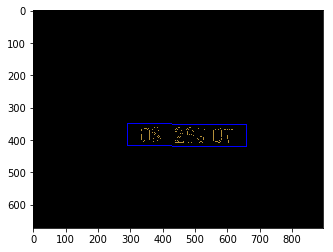

In [75]:
for i in range(0, len(listOfPossiblePlates)):
  p2fRectPoints = cv2.boxPoints(listOfPossiblePlates[i].rrLocationOfPlateInScene)
  cv2.line(imgContours, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), SCALAR_RED, 2)
  cv2.line(imgContours, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), SCALAR_RED, 2)
  cv2.line(imgContours, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), SCALAR_RED, 2)
  cv2.line(imgContours, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), SCALAR_RED, 2)
  
plot(imgContours)

## detect chars We get characters from plates

In [0]:
# this function first finds all contours, then only includes contours that 
# could be chars (without comparison to other chars yet)
        
def findPossibleCharsInPlate(imgGrayscale, imgThresh):
    listOfPossibleChars = [] 
    contours = []
    imgThreshCopy = imgThresh.copy()

    # find all contours in plate
    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:  # for each contour
        possibleChar = PossibleChar(contour)

        if checkIfPossibleChar(
                possibleChar):  # if contour is a possible char, note this does not compare to other chars (yet) . . .
            listOfPossibleChars.append(possibleChar)  # add to list of possible chars
        
    return listOfPossibleChars


In [0]:
# if we have two chars overlapping or to close to each other to possibly be separate chars, remove the inner (smaller) char,
# this is to prevent including the same char twice if two contours are found for the same char,
# for example for the letter 'O' both the inner ring and the outer ring may be found as contours, but we should only include the char once
def removeInnerOverlappingChars(listOfMatchingChars):
    listOfMatchingCharsWithInnerCharRemoved = list(listOfMatchingChars)  # this will be the return value

    for currentChar in listOfMatchingChars:
        for otherChar in listOfMatchingChars:
            if currentChar != otherChar:  # if current char and other char are not the same char . . .
                # if current char and other char have center points at almost the same location . . .
                if distanceBetweenChars(currentChar, otherChar) < (
                        currentChar.fltDiagonalSize * MIN_DIAG_SIZE_MULTIPLE_AWAY):
                    # if we get in here we have found overlapping chars
                    # next we identify which char is smaller, then if that char was not already removed on a previous pass, remove it
                    if currentChar.intBoundingRectArea < otherChar.intBoundingRectArea:  # if current char is smaller than other char
                        if currentChar in listOfMatchingCharsWithInnerCharRemoved:  # if current char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(currentChar)  # then remove current char
                        # end if
                    else:  # else if other char is smaller than current char
                        if otherChar in listOfMatchingCharsWithInnerCharRemoved:  # if other char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(otherChar)  # then remove other char
                        # end if
                    # end if
                # end if
            # end if
        # end for
    # end for

    return listOfMatchingCharsWithInnerCharRemoved

In [0]:
# this is where we apply the actual char recognition
def recognizeCharsInPlate(imgThresh, listOfMatchingChars):
    strChars = ""  # this will be the return value, the chars in the lic plate

    height, width = imgThresh.shape
    imgThreshColor = np.zeros((height, width, 3), np.uint8)
    thresholdValue, imgThresh = cv2.threshold(imgThresh, 0.0, 255.0, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    cv2.cvtColor(imgThresh, cv2.COLOR_GRAY2BGR, imgThreshColor)
    imgThreshColor2 = imgThreshColor.copy()
    listOfMatchingChars.sort(key=lambda matchingChar: matchingChar.intCenterX)  # sort chars from left to right

    for currentChar in listOfMatchingChars:  # for each char in plate
        pt1 = (currentChar.intBoundingRectX, currentChar.intBoundingRectY)
        pt2 = ((currentChar.intBoundingRectX + currentChar.intBoundingRectWidth),
               (currentChar.intBoundingRectY + currentChar.intBoundingRectHeight))

        cv2.rectangle(imgThreshColor2, pt1, pt2, (255, 0, 0), 2)  # draw green box around the char
        # crop char out of threshold image
        imgROI = imgThreshColor[
                 currentChar.intBoundingRectY: currentChar.intBoundingRectY + currentChar.intBoundingRectHeight,
                 currentChar.intBoundingRectX: currentChar.intBoundingRectX + currentChar.intBoundingRectWidth]
        imgROI = cv2.copyMakeBorder(imgROI, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=[255, 255, 255])

        # crop char out of threshold image
        imgROIResized = cv2.resize(imgROI, (RESIZED_CHAR_IMAGE_WIDTH, RESIZED_CHAR_IMAGE_HEIGHT),
                                   interpolation=cv2.INTER_LINEAR)  # resize image, this is necessary for char recognition
        """
        response = str(input('Want to save the image: '))
        if response == 'Y':
            name = str(input('Enter the name: '))
            cv2.imwrite(name, imgROIResized)
        """
        img = np.reshape(imgROIResized, [1, 64, 64, 3])

        classes = model.predict_classes(img)
        if classes[0] < 10:
            strCurrentChar = chr(classes[0] + 48)  # get character from results
        else:
            strCurrentChar = chr(classes[0] + 55)  # get character from results
        if showSteps == True:
            pass
        
        strChars = strChars + strCurrentChar  # append current char to full string

   
    if showSteps == True:  # show steps #######################################################
        imgThreshColor2 = Image.fromarray(imgThreshColor2, 'RGB')
        imgThreshColor2.show()
    #         input('Press Enter to Continue....')
    # end if # show steps #########################################################################

    return strChars

In [0]:
def preprocess(imgOriginal):
    imgGrayscale = extractValue(imgOriginal)  # We get the gray scale of the image.
    # imgGrayscale = cv2.equalizeHist(imgGrayscale)
    imgMaxContrastGrayscale = maximizeContrast(
        imgGrayscale)  # contrast is the difference between light and dark in an image. High contrast images will have bright highlights and dark shadows,bold colours, and show texture in the subject. Low contrast images will have a narrow range of tones and might therefore feel flat or dull

    imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE,
                                      0)  # 2nd parameter is (height,width) of Gaussian kernel,3rd parameter is sigmaX,4th parameter is sigmaY(as not specified it is made same as sigmaX).

    imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                                      ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)

    return imgGrayscale, imgThresh

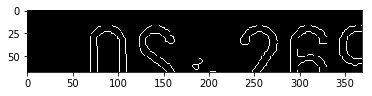

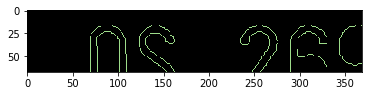

before


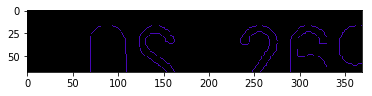

after.....


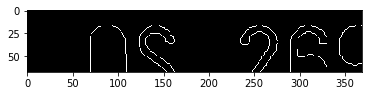

In [84]:
intPlateCounter = 0
contours = []

listOfPossiblePlates_refined = []
for possiblePlate in listOfPossiblePlates:
  possiblePlate.imgGrayscale, possiblePlate.imgThresh = preprocess(possiblePlate.imgPlate)
  
  possiblePlate.imgThresh = cv2.resize(possiblePlate.imgThresh, (0, 0), fx=1.6, fy=1.6, 
                                     interpolation=cv2.INTER_LINEAR)

  thresholdValue, possiblePlate.imgThresh = cv2.threshold(possiblePlate.imgThresh, 0.0, 255.0,
                                                        cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#   plot(possiblePlate)
  listOfPossibleCharsInPlate = findPossibleCharsInPlate(possiblePlate.imgGrayscale, possiblePlate.imgThresh)
  
  height, width, numChannels = possiblePlate.imgPlate.shape
  imgContours = np.zeros((height, width, 3), np.uint8)
  del contours[:]
  
  for possibleChar in listOfPossibleCharsInPlate:
    contours.append(possibleChar.contour)
    
  cv2.drawContours(imgContours, contours, -1, SCALAR_WHITE)
  plot(imgContours)
  
  # given a list of all possible chars, find groups of matching chars within the plate
  listOfListsOfMatchingCharsInPlate = findListOfListsOfMatchingChars(listOfPossibleCharsInPlate)
  
  if (len(listOfListsOfMatchingCharsInPlate) == 0):
    intPlateCounter = intPlateCounter + 1
    possiblePlate.strChars = ""
    continue
  
  imgContours = np.zeros((height, width, 3), np.uint8)
  del contours[:]
  
  for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
    intRandomBlue = random.randint(0, 255)
    intRandomGreen = random.randint(0, 255)
    intRandomRed = random.randint(0, 255)
    
    for matchingChar in listOfMatchingChars:
      contours.append(matchingChar.contour)
      
    cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
  
  plot(imgContours)
  
  for i in range(0, len(listOfListsOfMatchingCharsInPlate)):
    listOfListsOfMatchingCharsInPlate[i].sort(key=lambda matchingChar: matchingChar.intCenterX)
    listOfListsOfMatchingCharsInPlate[i] = removeInnerOverlappingChars(listOfListsOfMatchingCharsInPlate[i])
        
  imgContours = np.zeros((height, width, 3), np.uint8)
  for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
    intRandomBlue = random.randint(0, 255)
    intRandomGreen = random.randint(0, 255)
    intRandomRed = random.randint(0, 255)
    
    del contours[:]
    
    for matchingChar in listOfMatchingChars:
      contours.append(matchingChar.contour)
    
    cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
    
  print("before")
  plot(imgContours)
  
  # within each possible plate, suppose the longest list of potential matching chars is the actual list of chars
  intLenOfLongestListOfChars = 0
  intIndexOfLongestListOfChars = 0
  
  # loop through all the vectors of matching chars, get the index of the one with the most chars
  for i in range(0, len(listOfListsOfMatchingCharsInPlate)):
    if len(listOfListsOfMatchingCharsInPlate[i]) > intLenOfLongestListOfChars:
      intLenOfLongestListOfChars = len(listOfListsOfMatchingCharsInPlate[i])
      intIndexOfLongestListOfChars = i
  
  # suppose that the longest list of matching chars within the plate is the actual list of chars
  longestListOfMatchingCharsInPlate = listOfListsOfMatchingCharsInPlate[intIndexOfLongestListOfChars]
  
  imgContours = np.zeros((height, width, 3), np.uint8)
  del contours[:]
  
  for matchingChar in longestListOfMatchingCharsInPlate:
    contours.append(matchingChar.contour)
    
  cv2.drawContours(imgContours, contours, -1, SCALAR_WHITE)
  print("after.....")
  plot(imgContours)
  
  listOfPossiblePlates_refined.append(possiblePlate)
  
  intPlateCounter = intPlateCounter + 1 

In [0]:
def drawRedRectangleAroundPlate(imgOriginalScene, licPlate):
    # get 4 vertices of rotated rect. Here, bounding rectangle is drawn with
    # minimum area, so it considers the rotation also
    p2fRectPoints = cv2.boxPoints(licPlate.rrLocationOfPlateInScene)

    cv2.line(imgOriginalScene, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), SCALAR_RED, 2)  # draw 4 red lines
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), SCALAR_RED, 2)

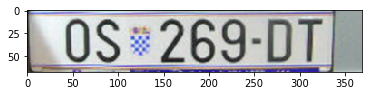

In [87]:
listOfPossiblePlates = listOfPossiblePlates_refined
if len(listOfPossiblePlates) == 0:
  response = ' '
  strChars, imgplate = response, imgOriginalScene
else:
  # sort the list of possible plates in DESCENDING order (most number of chars to least number of chars)
  listOfPossiblePlates.sort(key=lambda possiblePlate: len(possiblePlate.strChars), reverse=True)
  
  # suppose the plate with the most recognized chars (the first plate in sorted by string length descending
  # order) is the actual plate
  licPlate = listOfPossiblePlates[0]
  plot(licPlate.imgPlate)
  
  if len(licPlate.strChars) == 0:
    strChars, imgplate = ' ', imgOriginalScene
    
  drawRedRectangleAroundPlate(imgOriginalScene, licPlate)
  
  strChars, imgplate = licPlate.strChars, licPlate.imgPlate

In [103]:
import pytesseract
import re
num = pytesseract.image_to_string(imgplate)
print(re.sub('\W', '', num))

0S269DT
